In [39]:
import pandas as pd
import json
import glob
import os
from tqdm import tqdm

def load_patent_data(json_dir):
    important_fields = [
        'application_number', 'filing_date', 'title', 
        'abstract', 'decision', 'main_ipcr_label'
    ]
    
    patent_data = []
    json_files = glob.glob(os.path.join(json_dir, "*.json"))

    for file_path in tqdm(json_files, desc="Loading JSON files"):
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
                record = {field: data.get(field) for field in important_fields}
                patent_data.append(record)
            except json.JSONDecodeError:
                continue
    
    df = pd.DataFrame(patent_data)

    
    # Remove rows with NaN values on these columns
    df.dropna(subset=['decision','title','abstract', 'main_ipcr_label'], inplace=True)
    
    df = df[df['decision'].isin(['ACCEPTED', 'REJECTED'])]
    df['decision_binary'] = df['decision'].apply(lambda x: 1 if x == 'ACCEPTED' else 0)
    
    df['ipc_sub'] = df.main_ipcr_label.str[:4]

    return df


# df = load_patent_data("../dataset/sample/2016/")
df = load_patent_data("../dataset/2016/")
df.head(10)

Loading JSON files: 100%|██████████| 373255/373255 [02:28<00:00, 2520.10it/s]


,application_number,filing_date,title,abstract,decision,main_ipcr_label,decision_binary,ipc_sub
1,15070426,20160315,IMAGE-OUTPUTTING APPARATUS FOR OUTPUTTING NOTI...,An image-outputting apparatus includes a netwo...,ACCEPTED,H04N100,1,H04N
3,15060200,20160303,Refrigerated Well Tray,A refrigerated well tray provides a plurality ...,REJECTED,F25D308,0,F25D
9,15353547,20161116,SYSTEMS AND METHODS THAT ALLOW FOR SIMULTANEOU...,A sensor system with performance compensation ...,ACCEPTED,G01L2500,1,G01L
11,15319388,20161216,SEALING ARRANGEMENT,"A cassette sealing arrangement, for a vehicle,...",REJECTED,F16J1500,0,F16J
14,15176438,20160608,"FIXING BELT, FIXING DEVICE, AND IMAGE FORMING ...",A fixing belt includes a base layer made of a ...,ACCEPTED,G03G1520,1,G03G
15,15108364,20160627,STEERING COLUMN,"A steering column assembly for a vehicle, the ...",ACCEPTED,B62D1189,1,B62D
18,15105847,20160617,A METHOD FOR MANUFACTURING A HANDLE SUBSTRATE ...,This process includes steps: a) providing a ca...,ACCEPTED,H01L21683,1,H01L
24,15007821,20160127,Packet Based Delivery of Multi-Channel Audio o...,"The present disclosure is directed to systems,...",ACCEPTED,G10L1916,1,G10L
27,15201831,20160705,"IMAGE PROCESSING APPARATUS, DISTANCE MEASURING...",An image processing apparatus comprises a corr...,ACCEPTED,G06T700,1,G06T
28,15206467,20160711,LOCKABLE WAGERING CHIP CONTAINER AND METHOD FO...,A lockable wagering chip container is disclose...,ACCEPTED,A63F1100,1,A63F


### Daria para usar spacy, mas gastou muito tempo e, a princípio, não será necessário

In [40]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Run it once
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brunopc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brunopc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/brunopc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [41]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) # only a-z and spaces
    
    tokens = text.split()
    
    # Remove stopwords and lemmatize
    cleaned_tokens = []
    for token in tokens:
        if token not in stop_words:
            lemma = lemmatizer.lemmatize(token)
            cleaned_tokens.append(lemma)

    tokens = cleaned_tokens
    
    return " ".join(tokens)

tqdm.pandas()
df['title_processed'] = df['title'].fillna("").progress_apply(preprocess_text)
df['abstract_processed'] = df['abstract'].fillna("").progress_apply(preprocess_text)

df[['title_processed', 'abstract_processed']].head()


100%|██████████| 139805/139805 [00:20<00:00, 6908.53it/s]


,title_processed,abstract_processed
1,imageoutputting apparatus outputting notificat...,imageoutputting apparatus includes network int...
3,refrigerated well tray,refrigerated well tray provides plurality flex...
9,system method allow simultaneous sensor signal...,sensor system performance compensation testing...
11,sealing arrangement,cassette sealing arrangement vehicle providing...
14,fixing belt fixing device image forming apparatus,fixing belt includes base layer made heatresis...


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

df['combined_text'] = df['title_processed'] + ' ' + df['abstract_processed']

X = df['combined_text']
y = df['decision_binary']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer_temp = TfidfVectorizer()
X_temp = vectorizer_temp.fit_transform(df['combined_text'].sample(10000))
total_vocab = len(vectorizer_temp.vocabulary_)
print(f"Total vocabulary size: {total_vocab}")

features_amount = int(total_vocab * 0.8)  # 80% of vocabulary

Total vocabulary size: 24315


In [43]:
vectorizer = TfidfVectorizer(
    max_features=features_amount,   # Set based on vocabulary analysis 
    ngram_range=(1, 3),             # Include 3 word phrases
    min_df=2,                       # Ignore words appearing in <5 documents
    max_df=0.95,                    # Ignore words appearing in >95% documents
    sublinear_tf=True               # Use log scaling for term frequency (@TODO TEST BOTH OPTIONS)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

    REJECTED       0.28      0.50      0.36      4865
    ACCEPTED       0.87      0.73      0.80     23096

    accuracy                           0.69     27961
   macro avg       0.58      0.61      0.58     27961
weighted avg       0.77      0.69      0.72     27961


Confusion Matrix:
[[ 2409  2456]
 [ 6214 16882]]

True Positives (TP): 16882
True Negatives (TN): 2409
False Positives (FP): 2456
False Negatives (FN): 6214


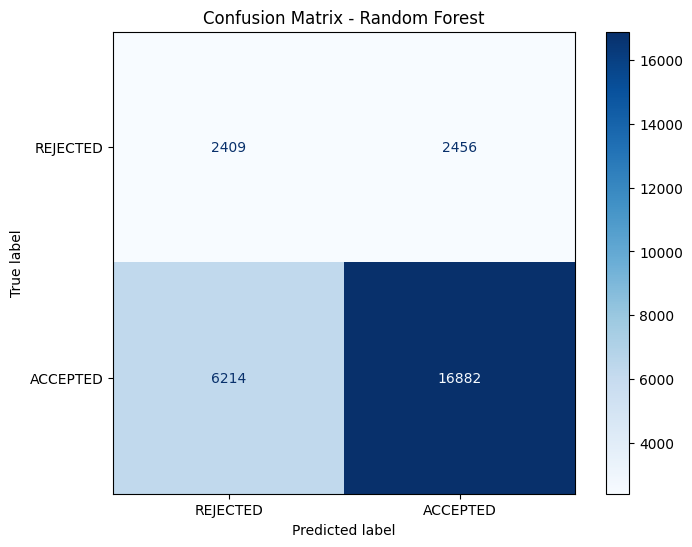

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

random_forest_model = RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,                  # Use all CPU cores
        max_depth=20,               # Helps preventing overfitting
        class_weight='balanced'     # Handle class imbalance (accepted>rejected)
    )

print(f"Training Random Forest...")
random_forest_model.fit(X_train_vec, y_train)

y_pred = random_forest_model.predict(X_test_vec)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['REJECTED', 'ACCEPTED']))

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REJECTED', 'ACCEPTED']).plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix - Random Forest')
plt.show()

### Está bem diferente o resultado de REJECTED e ACCEPTED. Entendendo a proporção:

In [45]:
print("Class distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in test set:")
print(y_test.value_counts())
print("\nPrediction distribution:")
print(pd.Series(y_pred).value_counts())

Class distribution in training set:
decision_binary
1    92384
0    19460
Name: count, dtype: int64

Class distribution in test set:
decision_binary
1    23096
0     4865
Name: count, dtype: int64

Prediction distribution:
1    19338
0     8623
Name: count, dtype: int64


### Testando logistic regression:


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    REJECTED       0.28      0.60      0.38      4865
    ACCEPTED       0.89      0.68      0.77     23096

    accuracy                           0.67     27961
   macro avg       0.59      0.64      0.58     27961
weighted avg       0.78      0.67      0.70     27961


Confusion Matrix:
[[ 2905  1960]
 [ 7404 15692]]

True Positives (TP): 15692
True Negatives (TN): 2905
False Positives (FP): 1960
False Negatives (FN): 7404


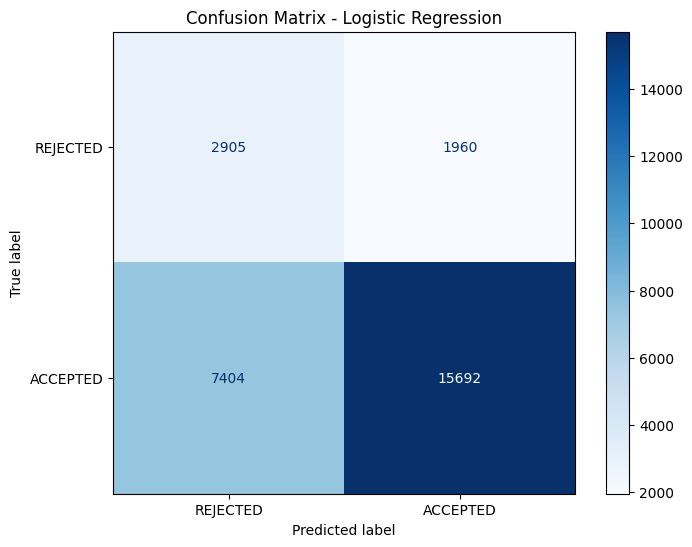

In [46]:
from sklearn.linear_model import LogisticRegression

#AI-suggested parameters:
lr = LogisticRegression(
    solver='saga',           # Efficient for large datasets
    C=0.1,                   # Stronger regularization to prevent overfitting
    max_iter=3000,           # More iterations for convergence
    tol=1e-4,                # Convergence tolerance
    n_jobs=-1,               
    class_weight='balanced'  
)
lr.fit(X_train_vec, y_train)

y_pred = lr.predict(X_test_vec)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=['REJECTED','ACCEPTED']))

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REJECTED', 'ACCEPTED']).plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()